In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
X.shape

(150, 4)

In [5]:
import pandas as pd
pd.DataFrame(X)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [13]:
#降维，维度为2
pca = PCA(n_components=2) 
pca = pca.fit(X) 
new_X = pca.transform(X) 
new_X

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

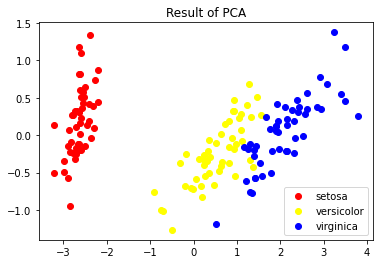

In [24]:
plt.figure()
plt.scatter(new_X[y==0, 0], new_X[y==0, 1], c="red", label=iris.target_names[0])
plt.scatter(new_X[y==1, 0], new_X[y==1, 1], c="yellow", label=iris.target_names[1])
plt.scatter(new_X[y==2, 0], new_X[y==2, 1], c="blue", label=iris.target_names[2])
plt.legend()
plt.title('Result of PCA')
plt.show()

In [10]:
pca.explained_variance_

array([4.22824171, 0.24267075])

In [11]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [12]:
pca. explained_variance_ratio_.sum()


0.977685206318795

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

import cooler
import cooltools.lib.plotting

from packaging import version
import cooltools

GM12878_1M = cooler.Cooler('./test.cool')

In [ ]:
## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('./hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz --no-check-certificate', shell=True)
    subprocess.call('gunzip hg38.fa.gz', shell=True)
    

In [ ]:
import bioframe
bins = GM12878_1M.bins()[:]
hg38_genome = bioframe.load_fasta('./hg38.fa');
## note the next command may require installing pysam
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')
display(gc_cov)

In [ ]:
view_df = pd.DataFrame({'chrom': GM12878_1M.chromnames,
                        'start': 0,
                        'end': GM12878_1M.chromsizes.values,
                        'name': GM12878_1M.chromnames}
                      )
display(view_df)

In [ ]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        GM12878_1M,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    GM12878_1M.matrix(balance=True).fetch('chrX:20MB-40MB'),
    norm=norm,
    cmap='fall'
);
plt.axis([0,200,200,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
weights = GM12878_1M.bins().fetch('chrX:20MB-40MB')['weight'].values
ax1.plot([0,200],[0,0],'k',lw=0.25)
ax1.plot( eigenvector_track[eigenvector_track['chrom']=='chrX'][200:400]['E1'].values, label='E1',lw=1)

ax1.set_ylabel('E1')
#ax1.set_xticks([]);


for i in np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX'][200:400]['E1']>0).astype(int)))[0]:
    ax.plot([0, 200],[i,i],'k',lw=0.5)
    ax.plot([i,i],[0, 200],'k',lw=0.5)